In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import mean
import torch
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from torch.utils import data as D
import torch
from PIL import Image
import os
import glob
import os.path as osp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset1

In [ ]:
import pandas as pd
import numpy as np
import csv
df = pd.read_csv("/content/drive/MyDrive/training-a.csv",usecols = ['filename', 'digit'],encoding="utf8")

In [ ]:
df.head

<bound method NDFrame.head of          filename  digit
0      a00000.png      5
1      a00001.png      3
2      a00002.png      1
3      a00003.png      7
4      a00004.png      0
...           ...    ...
19697  a19697.png      4
19698  a19698.png      3
19699  a19699.png      8
19700  a19700.png      3
19701  a19701.png      8

[19702 rows x 2 columns]>

In [ ]:
batch_size = 20;
num_iters = 20000;
input_dim = 180 * 180; #num_features = 32400
output_dim = 10;
learning_rate = 0.01;
num_nodes_in_hidden_layers = 200;
num_hidden_layers = 6;
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device);

cuda:0


In [ ]:
path = '/content/drive/MyDrive/training-a';

In [ ]:
import torch.nn as nn;
class imageDataset(D.Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(180),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [ ]:
full_dataset  = imageDataset(df, path, train_transform)

In [ ]:
dataset_size = len(full_dataset);
print(dataset_size);
indices = list(range(dataset_size));
train_dataset_len = int(np.floor(0.8 * dataset_size))
print(train_dataset_len);
test_dataset_len = dataset_size - train_dataset_len;
print(test_dataset_len);
train_dataset, test_dataset = D.random_split(full_dataset, lengths=[train_dataset_len, test_dataset_len]);
print(train_dataset);
print(test_dataset);

19702
15761
3941


In [ ]:
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [ ]:
# INSTANTIATE MODEL CLASS
 
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_nodes_in_hidden_layers)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=32400, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 180*180).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.301680326461792. Accuracy: 10.37807663029688
Iteration: 1000. Loss: 2.3032031059265137. Accuracy: 10.200456736868816
Iteration: 1500. Loss: 2.302762508392334. Accuracy: 11.41842172037554
Iteration: 2000. Loss: 2.3036646842956543. Accuracy: 10.276579548337985
Iteration: 2500. Loss: 2.2951059341430664. Accuracy: 13.87972595787871
Iteration: 3000. Loss: 2.2907204627990723. Accuracy: 9.337731540218218
Iteration: 3500. Loss: 2.299895763397217. Accuracy: 14.108094392286223
Iteration: 4000. Loss: 2.2640507221221924. Accuracy: 14.742451154529308
Iteration: 4500. Loss: 2.24876070022583. Accuracy: 16.670895711748287
Iteration: 5000. Loss: 2.2791638374328613. Accuracy: 15.858919056077138
Iteration: 5500. Loss: 2.245816946029663. Accuracy: 14.514082720121797
Iteration: 6000. Loss: 2.252570152282715. Accuracy: 17.533620908398884
Iteration: 6500. Loss: 2.513288974761963. Accuracy: 18.269474752600864
Iteration: 7000. Loss: 2.262970447540283. Accuracy: 17.711240801826946
Iterat

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

root_path = '/content/drive/MyDrive/'

Mounted at /content/drive


In [ ]:
save_model = True

if save_model is True:
    # Saves only parameters
    # weights & biases
    torch.save(model.state_dict(), root_path + 'MNIST_logistic.pkl') 

In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'MNIST_logistic.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/model_base.pkl')

**batch_size = 50 , layer 7**

In [ ]:
batch_size = 50;
num_iters = 30000;
input_dim = 180 * 180; #num_features = 32400
output_dim = 10;
learning_rate = 0.1;
num_nodes_in_hidden_layers = 200;
num_hidden_layers = 7;
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device);

cuda:0


In [ ]:
class imageDataset(D.Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(180),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
full_dataset  = imageDataset(df, path, train_transform)

In [ ]:
full_dataset[0]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]), 5)

In [ ]:
dataset_size = len(full_dataset);
print(dataset_size);
indices = list(range(dataset_size));
train_dataset_len = int(np.floor(0.8 * dataset_size))
print(train_dataset_len);
test_dataset_len = dataset_size - train_dataset_len;
print(test_dataset_len);
train_dataset, test_dataset = D.random_split(full_dataset, lengths=[train_dataset_len, test_dataset_len]);
print(len(train_dataset));
print(len(test_dataset));

19702
15761
3941
15761
3941


In [ ]:
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

print(len(train_loader));
print(len(test_loader));

316
79


In [ ]:
import torch.nn as nn
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        
        self.relu_1 = nn.ReLU()
 
        
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_2 = nn.ReLU()
 
        
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_3 = nn.ReLU()
        
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()

        self.linear_7 = nn.Linear(num_hidden, num_hidden)
        self.relu_7 = nn.ReLU()
        
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
 
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4rd hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_4(out)

        ### 5rd hidden layer
        out  = self.linear_5(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_5(out)

        ### 6rd hidden layer
        out  = self.linear_6(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_6(out)

        ### 7rd hidden layer
        out  = self.linear_7(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_7(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas
 


 


In [ ]:
# INSTANTIATE MODEL CLASS
 
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_nodes_in_hidden_layers)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=32400, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_7): Linear(in_features=200, out_features=200, bias=True)
  (relu_7): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
 
        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)
 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
 
        # Forward pass to get output/logits
        outputs = model(images) 
 
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
 
        # Getting gradients w.r.t. parameters
        loss.backward()
 
        # Updating parameters
        optimizer.step()
 
        iter += 1
 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 180*180).to(device)
 
                # Forward pass only to get logits/output
                outputs = model(images)
 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
 
                # Total number of labels
                total += labels.size(0)
 
 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()
 
            accuracy = 100 * correct.item() / total
             
            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.3143389225006104. Accuracy: 10.022836843440752
Iteration: 1000. Loss: 2.272994041442871. Accuracy: 9.769094138543517
Iteration: 1500. Loss: 2.2938029766082764. Accuracy: 15.402182187262117
Iteration: 2000. Loss: 2.2469239234924316. Accuracy: 13.169246384166454
Iteration: 2500. Loss: 2.2138471603393555. Accuracy: 17.482872367419436
Iteration: 3000. Loss: 2.1337063312530518. Accuracy: 17.939609236234457
Iteration: 3500. Loss: 2.3057618141174316. Accuracy: 13.905100228368434
Iteration: 4000. Loss: 2.1445350646972656. Accuracy: 19.994925145902055
Iteration: 4500. Loss: 2.0772593021392822. Accuracy: 20.75615326059376
Iteration: 5000. Loss: 2.1278514862060547. Accuracy: 15.985790408525755
Iteration: 5500. Loss: 2.0587081909179688. Accuracy: 19.868053793453438
Iteration: 6000. Loss: 2.0540764331817627. Accuracy: 12.331895458005583
Iteration: 6500. Loss: 2.0957529544830322. Accuracy: 20.629281908145142
Iteration: 7000. Loss: 1.9659733772277832. Accuracy: 24.004059883278

[2.3143389225006104, 2.272994041442871, 2.2938029766082764, 2.2469239234924316, 2.2138471603393555, 2.1337063312530518, 2.3057618141174316, 2.1445350646972656, 2.0772593021392822, 2.1278514862060547, 2.0587081909179688, 2.0540764331817627, 2.0957529544830322, 1.9659733772277832, 2.111366033554077, 1.8948866128921509, 2.054602861404419, 1.8784124851226807, 1.8321621417999268, 1.8174827098846436, 1.8769967555999756, 2.0396082401275635, 1.8142156600952148, 1.8296988010406494, 1.9596717357635498, 1.7220150232315063, 1.7039440870285034, 1.8560447692871094, 1.8200138807296753, 1.7400124073028564, 1.7443292140960693, 1.790134310722351, 1.7650636434555054, 1.7379146814346313, 1.7256994247436523, 1.7418757677078247, 1.9414660930633545, 1.6151007413864136, 1.4423964023590088, 1.8276817798614502, 1.8726452589035034, 1.5181033611297607, 1.6751834154129028, 1.7681790590286255, 1.6161205768585205, 1.5721631050109863, 1.4671443700790405, 1.4199836254119873, 1.544395089149475, 1.5797234773635864, 1.62

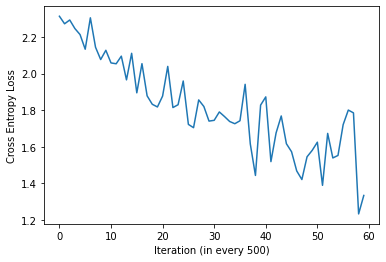

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [ ]:
loss_for_first_attempt = [2.3143389225006104, 2.272994041442871, 2.2938029766082764, 2.2469239234924316, 2.2138471603393555, 2.1337063312530518, 2.3057618141174316, 2.1445350646972656, 2.0772593021392822, 2.1278514862060547, 2.0587081909179688, 2.0540764331817627, 2.0957529544830322, 1.9659733772277832, 2.111366033554077, 1.8948866128921509, 2.054602861404419, 1.8784124851226807, 1.8321621417999268, 1.8174827098846436, 1.8769967555999756, 2.0396082401275635, 1.8142156600952148, 1.8296988010406494, 1.9596717357635498, 1.7220150232315063, 1.7039440870285034, 1.8560447692871094, 1.8200138807296753, 1.7400124073028564, 1.7443292140960693, 1.790134310722351, 1.7650636434555054, 1.7379146814346313, 1.7256994247436523, 1.7418757677078247, 1.9414660930633545, 1.6151007413864136, 1.4423964023590088, 1.8276817798614502, 1.8726452589035034, 1.5181033611297607, 1.6751834154129028, 1.7681790590286255, 1.6161205768585205, 1.5721631050109863, 1.4671443700790405, 1.4199836254119873, 1.544395089149475, 1.5797234773635864, 1.6245429515838623, 1.3881866931915283, 1.672644019126892, 1.5382722616195679, 1.5519354343414307, 1.7205109596252441, 1.8004473447799683, 1.7851405143737793, 1.2316819429397583, 1.332791805267334]

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

root_path = '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
save_model = True

if save_model is True:
    # Saves only parameters
    # weights & biases
    torch.save(model.state_dict(), root_path + 'MNIST_logistic.pkl') 

In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'MNIST_logistic.pkl'))
    print('Trained Model Loaded')

Testing Loaded Model with Digits

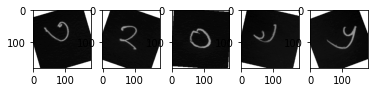

In [ ]:
for images, labels in test_loader:
    break
    
fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(images[i].view(180, 180), cmap=matplotlib.cm.binary)

plt.show()

In [ ]:
_, predictions = model.forward(images[:5].view(-1, 180*180).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

# batch size 90, hidden layer 3

In [ ]:
batch_size = 90;
num_iters = 30000;
input_dim = 180 * 180; #num_features = 32400
output_dim = 10;
learning_rate = 0.01;
num_nodes_in_hidden_layers = 200;
num_hidden_layers = 3;
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device);

cuda:0


In [ ]:
class imageDataset(D.Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(180),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [ ]:
full_dataset  = imageDataset(df, path, train_transform)

In [ ]:
dataset_size = len(full_dataset);
print(dataset_size);
indices = list(range(dataset_size));
train_dataset_len = int(np.floor(0.7 * dataset_size))
print(train_dataset_len);
test_dataset_len = dataset_size - train_dataset_len;
print(test_dataset_len);
train_dataset, test_dataset = D.random_split(full_dataset, lengths=[train_dataset_len, test_dataset_len]);
print(len(train_dataset));
print(len(test_dataset));


19702
13791
5911
13791
5911


In [ ]:
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

print(len(train_loader));
print(len(test_loader));

154
66


In [ ]:
import torch.nn as nn
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        
        self.relu_1 = nn.ReLU()
 
        
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_2 = nn.ReLU()
 
        
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_3 = nn.ReLU()
 
        
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
 
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas
 


 


In [ ]:
# INSTANTIATE MODEL CLASS
 
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_nodes_in_hidden_layers)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=32400, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
 
        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)
 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
 
        # Forward pass to get output/logits
        outputs = model(images) 
 
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
 
        # Getting gradients w.r.t. parameters
        loss.backward()
 
        # Updating parameters
        optimizer.step()
 
        iter += 1
 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 180*180).to(device)
 
                # Forward pass only to get logits/output
                outputs = model(images)
 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
 
                # Total number of labels
                total += labels.size(0)
 
 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()
 
            accuracy = 100 * correct.item() / total
 
            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.2719855308532715. Accuracy: 12.01150397563864
Iteration: 1000. Loss: 2.1597437858581543. Accuracy: 10.539671798342074
Iteration: 1500. Loss: 2.251554012298584. Accuracy: 24.54745389950939
Iteration: 2000. Loss: 2.1192123889923096. Accuracy: 27.321942141769583
Iteration: 2500. Loss: 2.1150128841400146. Accuracy: 27.49111825410252
Iteration: 3000. Loss: 2.104428291320801. Accuracy: 19.42141769582135
Iteration: 3500. Loss: 1.6142348051071167. Accuracy: 37.04956860091355
Iteration: 4000. Loss: 1.9666699171066284. Accuracy: 29.487396379631196
Iteration: 4500. Loss: 1.838463306427002. Accuracy: 38.284554220944
Iteration: 5000. Loss: 1.6744099855422974. Accuracy: 34.74877347318559
Iteration: 5500. Loss: 2.057133913040161. Accuracy: 36.55895787514803
Iteration: 6000. Loss: 1.7008583545684814. Accuracy: 37.472508881745895
Iteration: 6500. Loss: 1.5060031414031982. Accuracy: 35.76383014718322
Iteration: 7000. Loss: 1.7747509479522705. Accuracy: 43.02148536626628
Iteration

[2.2719855308532715, 2.1597437858581543, 2.251554012298584, 2.1192123889923096, 2.1150128841400146, 2.104428291320801, 1.6142348051071167, 1.9666699171066284, 1.838463306427002, 1.6744099855422974, 2.057133913040161, 1.7008583545684814, 1.5060031414031982, 1.7747509479522705, 1.3043291568756104, 1.5472395420074463, 1.665347933769226, 1.6566365957260132, 1.5737894773483276, 1.2840489149093628, 1.3166282176971436, 1.5129199028015137, 1.8352001905441284, 1.225209355354309, 1.32243812084198, 0.9144057631492615, 1.1200170516967773, 1.1669389009475708, 1.1349852085113525, 0.903861939907074, 1.1295720338821411, 1.2183260917663574, 1.3291912078857422, 0.8927881121635437, 1.056113839149475, 0.8660226464271545, 0.8713282346725464, 0.9351924657821655, 0.931793749332428, 0.8555002808570862, 0.7964465618133545, 0.8538241982460022, 0.7256215214729309, 0.8058335185050964, 0.8004300594329834, 0.7530235052108765, 0.8992728590965271, 0.7471644282341003, 0.8360752463340759, 0.9876490235328674, 0.68700593

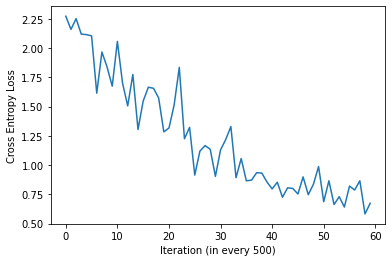

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [ ]:
loss_for_second_attempt = [2.2719855308532715, 2.1597437858581543, 2.251554012298584, 2.1192123889923096, 2.1150128841400146, 2.104428291320801, 1.6142348051071167, 1.9666699171066284, 1.838463306427002, 1.6744099855422974, 2.057133913040161, 1.7008583545684814, 1.5060031414031982, 1.7747509479522705, 1.3043291568756104, 1.5472395420074463, 1.665347933769226, 1.6566365957260132, 1.5737894773483276, 1.2840489149093628, 1.3166282176971436, 1.5129199028015137, 1.8352001905441284, 1.225209355354309, 1.32243812084198, 0.9144057631492615, 1.1200170516967773, 1.1669389009475708, 1.1349852085113525, 0.903861939907074, 1.1295720338821411, 1.2183260917663574, 1.3291912078857422, 0.8927881121635437, 1.056113839149475, 0.8660226464271545, 0.8713282346725464, 0.9351924657821655, 0.931793749332428, 0.8555002808570862, 0.7964465618133545, 0.8538241982460022, 0.7256215214729309, 0.8058335185050964, 0.8004300594329834, 0.7530235052108765, 0.8992728590965271, 0.7471644282341003, 0.8360752463340759, 0.9876490235328674, 0.6870059370994568, 0.8660443425178528, 0.6632782816886902, 0.7299994826316833, 0.641609787940979, 0.8208457827568054, 0.787122368812561, 0.8659520745277405, 0.582880973815918, 0.673609733581543]

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

root_path = '/content/drive/MyDrive/'

Mounted at /content/drive


In [ ]:
save_model = True

if save_model is True:
    # Saves only parameters
    # weights & biases
    torch.save(model.state_dict(), root_path + 'MNIST_logistic.pkl') 

In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'MNIST_logistic.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


# batch size 250, layer 6

In [ ]:
batch_size = 200;
num_iters = 20000;
input_dim = 180 * 180; #num_features = 32400
output_dim = 10;
learning_rate = 0.01;
num_nodes_in_hidden_layers = 200;
num_hidden_layers = 6;
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device);

cpu


In [ ]:
class imageDataset(D.Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(180),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [ ]:
full_dataset  = imageDataset(df, path, train_transform)

In [ ]:
dataset_size = len(full_dataset);
print(dataset_size);
indices = list(range(dataset_size));
train_dataset_len = int(np.floor(0.8 * dataset_size))
print(train_dataset_len);
test_dataset_len = dataset_size - train_dataset_len;
print(test_dataset_len);
train_dataset, test_dataset = D.random_split(full_dataset, lengths=[train_dataset_len, test_dataset_len]);
print(train_dataset);
print(test_dataset);

19702
15761
3941


In [ ]:
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

print(len(train_loader));
print(len(test_loader));

79
20


In [ ]:
import torch.nn as nn
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        
        self.relu_1 = nn.ReLU()
 
        
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_2 = nn.ReLU()
 
        
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_3 = nn.ReLU()
        
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()

        
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
 
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4rd hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_4(out)

        ### 5rd hidden layer
        out  = self.linear_5(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_5(out)

        ### 6rd hidden layer
        out  = self.linear_6(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_6(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas
 


 


In [ ]:
# INSTANTIATE MODEL CLASS
 
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_nodes_in_hidden_layers)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=32400, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
 
        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)
 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
 
        # Forward pass to get output/logits
        outputs = model(images) 
 
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
 
        # Getting gradients w.r.t. parameters
        loss.backward()
 
        # Updating parameters
        optimizer.step()
 
        iter += 1
 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 180*180).to(device)
 
                # Forward pass only to get logits/output
                outputs = model(images)
 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
 
                # Total number of labels
                total += labels.size(0)
 
 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()
 
            accuracy = 100 * correct.item() / total
 
            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.302621364593506. Accuracy: 9.819842679522964
Iteration: 1000. Loss: 2.301548480987549. Accuracy: 10.124333925399645
Iteration: 1500. Loss: 2.302006483078003. Accuracy: 11.900532859680284
Iteration: 2000. Loss: 2.300976514816284. Accuracy: 9.464602892666836
Iteration: 2500. Loss: 2.3018577098846436. Accuracy: 9.464602892666836
Iteration: 3000. Loss: 2.3013222217559814. Accuracy: 9.464602892666836
Iteration: 3500. Loss: 2.3002212047576904. Accuracy: 9.464602892666836
Iteration: 4000. Loss: 2.2958855628967285. Accuracy: 9.972088302461303
Iteration: 4500. Loss: 2.289156913757324. Accuracy: 11.190053285968029
Iteration: 5000. Loss: 2.2839391231536865. Accuracy: 16.493275818320225
Iteration: 5500. Loss: 2.3161890506744385. Accuracy: 16.4679015478305
Iteration: 6000. Loss: 2.2557754516601562. Accuracy: 19.918802334432886
Iteration: 6500. Loss: 2.0585124492645264. Accuracy: 18.650088809946713
Iteration: 7000. Loss: 1.9908103942871094. Accuracy: 18.294849023090585
Iterat

In [ ]:
iterations = list(range(500,30500,500));
print(len(iterations));

60


# **loss vs iteration graph **

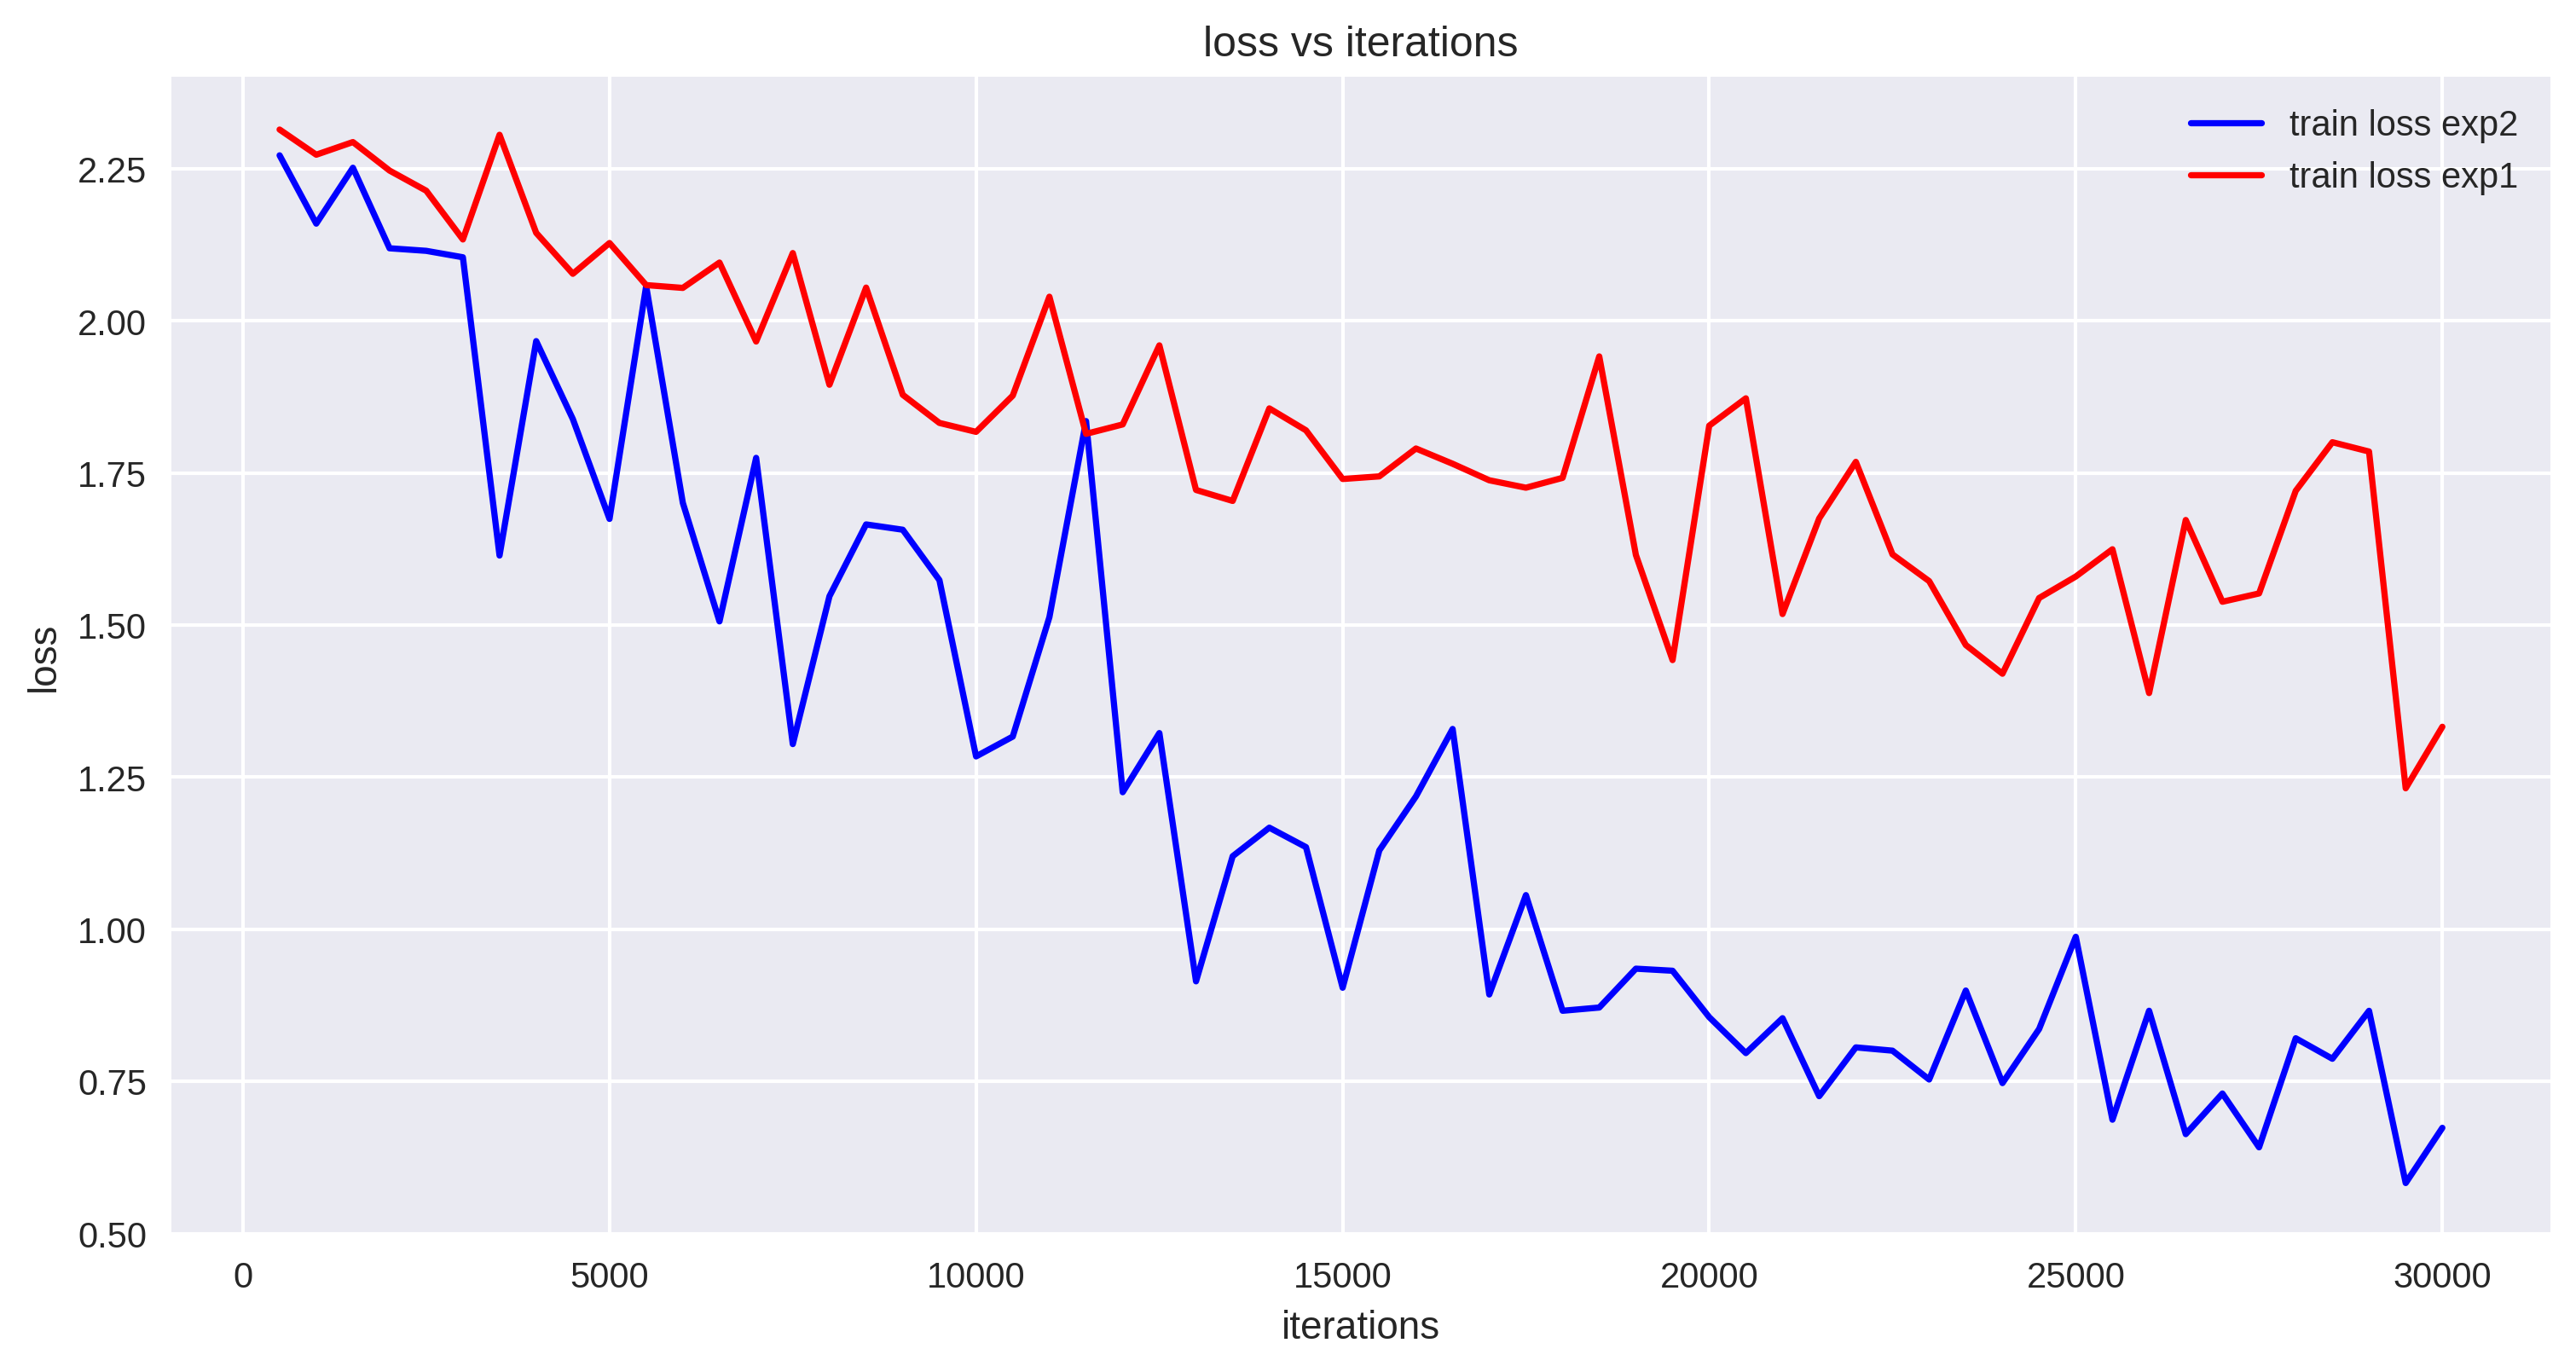

In [ ]:
plt.figure(figsize=(12,6),dpi=300);
plt.style.use('seaborn');

plt.plot(iterations , loss_for_second_attempt, color='blue',label='train loss exp2');
plt.plot(iterations , loss_for_first_attempt, color='red',label='train loss exp1');
plt.title('loss vs iterations');
plt.xlabel('iterations');
plt.ylabel('loss');
plt.grid(True); #create a grid layout
plt.legend();
plt.show()

**Dataset2**

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/verification_train.csv");
print(train_df.head(5));

   label  pixel1  pixel2  pixel3  ...  pixel781  pixel782  pixel783  pixel784
0      2       0       0       0  ...         0         0         0         0
1      9       0       0       0  ...         0         0         0         0
2      6       0       0       0  ...         0         0         0         0
3      0       0       0       0  ...         0         0         0         0
4      3       0       0       0  ...         0         0         0         0

[5 rows x 785 columns]


In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/verification_test.csv");
print(test_df.head(5));

   label  pixel1  pixel2  pixel3  ...  pixel781  pixel782  pixel783  pixel784
0      0       0       0       0  ...         0         0         0         0
1      1       0       0       0  ...         0         0         0         0
2      2       0       0       0  ...        31         0         0         0
3      2       0       0       0  ...       222        56         0         0
4      3       0       0       0  ...         0         0         0         0

[5 rows x 785 columns]


In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import math;
from matplotlib.pyplot import imshow

4
784
28
Label: 4


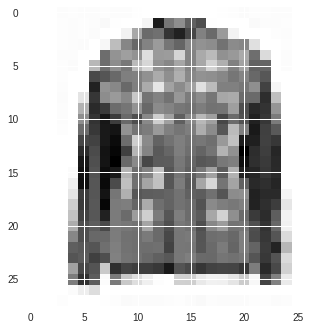

In [ ]:
i = 5 # set any valid index of an image
label = train_df.values[i][0] # retrieve label from first colum in dataframe
print(label)
im_buf = train_df.values[i][1:] # create flat array of only the pixels of the given image
print(len(im_buf)); 
axis_len = int(math.sqrt(im_buf.shape[0])) # calculate the dimensions of the square image
print(axis_len);
im_array = np.int8(np.reshape(im_buf, (axis_len, axis_len))) # create a 2D array from flat array
img = Image.fromarray(im_array, 'L') # convert to a PIL.Image object ('L' is for grayscale)

print(f'Label: {label}')
imshow(np.asarray(img))

In [ ]:
train_df['pixel12'] = train_df['pixel12'] / 255;
for i in train_df['pixel12']:
  print(i);


Streaming output truncated to the last 5000 lines.
0.8
0.19215686274509805
0.0
0.2196078431372549
0.0
0.48627450980392156
0.0
0.00392156862745098
0.0
0.0
0.0
0.0
0.0
0.011764705882352941
0.23921568627450981
0.8901960784313725
0.0
0.01568627450980392
0.1607843137254902
0.0
0.0
0.403921568627451
0.5137254901960784
0.34901960784313724
0.0
0.0
0.0
0.0
0.0
0.8117647058823529
0.0
0.0
0.0
0.8431372549019608
0.43529411764705883
0.5725490196078431
0.0
0.0
0.0
0.0
0.5490196078431373
0.15294117647058825
0.0
0.0
0.7725490196078432
0.00784313725490196
0.27450980392156865
0.058823529411764705
0.0
0.9058823529411765
0.0
0.0
0.6352941176470588
0.0
0.7490196078431373
0.5098039215686274
0.0
0.3058823529411765
0.0
0.09019607843137255
0.6627450980392157
0.0
0.41568627450980394
0.0
0.0
0.40784313725490196
0.0
0.0
0.0
0.0
0.9725490196078431
0.0
0.0
0.0
0.0
0.40784313725490196
0.5372549019607843
0.0
0.0
0.0
0.0
0.27058823529411763
0.39215686274509803
0.00392156862745098
0.0
0.40784313725490196
0.0
0.0
0.1960

**datalabel**

In [ ]:
test_label=test_df['label']

train_label=train_df['label']
data_names=[test_label,train_label]
all_labels=pd.concat(data_names,ignore_index=True)
print(all_labels);

0        0
1        1
2        2
3        2
4        3
        ..
69995    9
69996    1
69997    8
69998    8
69999    7
Name: label, Length: 70000, dtype: int64


In [ ]:
data_name=[test_df,train_df]
all_image=pd.concat(data_name,ignore_index=True)
all_image=all_image.drop(labels='label',axis=1)
print(all_image.shape)
print(all_image);

(70000, 784)
       pixel1  pixel2  pixel3  pixel4  ...  pixel781  pixel782  pixel783  pixel784
0           0       0       0       0  ...         0         0         0         0
1           0       0       0       0  ...         0         0         0         0
2           0       0       0       0  ...        31         0         0         0
3           0       0       0       0  ...       222        56         0         0
4           0       0       0       0  ...         0         0         0         0
...       ...     ...     ...     ...  ...       ...       ...       ...       ...
69995       0       0       0       0  ...         0         0         0         0
69996       0       0       0       0  ...         0         0         0         0
69997       0       0       0       0  ...         0         0         0         0
69998       0       0       0       0  ...         0         0         0         0
69999       0       0       0       0  ...         0         0         0  

**normalize**

In [ ]:
all_image=all_image/255.0

**reshape**

In [ ]:
all_image=all_image.values.reshape(-1,28,28,1)

**printing image**

0


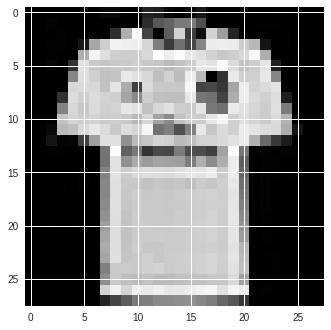

In [ ]:
show_img = all_image[0].reshape(28, 28)
plt.imshow(show_img, cmap='gray')
print(all_labels[0])

# spliting

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_image, all_labels, test_size=0.2)

**zipped**

In [ ]:
train_dataset_zipped = list(zip(X_train,y_train))
test_dataset_zipped = list(zip(X_test,y_test))
print(len(train_dataset_zipped))
print(len(test_dataset_zipped))

56000
14000


In [ ]:
batch_size = 20;
num_iters = 20000;
input_dim = 28*28; #num_features = 784
output_dim = 10;
learning_rate = 0.01;
num_nodes_in_hidden_layers = 200;
num_hidden_layers = 6;
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device);

cuda:0


In [ ]:
num_epochs = num_iters / (len(train_dataset_zipped) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset_zipped, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset_zipped, 
                                          batch_size=batch_size, 
                                          shuffle=False) 
print(len(train_loader));
print(len(test_loader));

2800
700


In [ ]:
import torch.nn as nn
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        
        self.relu_1 = nn.ReLU()
 
        
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_2 = nn.ReLU()
 
        
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_3 = nn.ReLU()
 
         
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_4 = nn.ReLU()
 
         
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        
        self.relu_5= nn.ReLU()
 
         
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_6 = nn.ReLU()
 
        
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
 
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_6(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [ ]:

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_nodes_in_hidden_layers)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
Iteration_loss =[]
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
 
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
 
        # Forward pass to get output/logits
        outputs = model(images.float()) 
 
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
 
        # Getting gradients w.r.t. parameters
        loss.backward()
 
        # Updating parameters
        optimizer.step()
 
        iter += 1
 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)
 
                # Forward pass only to get logits/output
                outputs = model(images.float())
 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
 
                # Total number of labels
                total += labels.size(0)
 
 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()
 
            accuracy = 100 * correct.item() / total
 
            # Print Loss
            Iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.3017754554748535. Accuracy: 10.207142857142857
Iteration: 1000. Loss: 2.302272319793701. Accuracy: 10.35
Iteration: 1500. Loss: 2.301154136657715. Accuracy: 10.064285714285715
Iteration: 2000. Loss: 2.299434185028076. Accuracy: 13.871428571428572
Iteration: 2500. Loss: 2.2942798137664795. Accuracy: 24.42142857142857
Iteration: 3000. Loss: 2.2633979320526123. Accuracy: 24.021428571428572
Iteration: 3500. Loss: 1.9391109943389893. Accuracy: 24.34285714285714
Iteration: 4000. Loss: 1.0206376314163208. Accuracy: 57.72857142857143
Iteration: 4500. Loss: 0.742240846157074. Accuracy: 57.84285714285714
Iteration: 5000. Loss: 1.4283835887908936. Accuracy: 61.292857142857144
Iteration: 5500. Loss: 0.7141459584236145. Accuracy: 64.14285714285714
Iteration: 6000. Loss: 0.3926504850387573. Accuracy: 72.35
Iteration: 6500. Loss: 0.6637511253356934. Accuracy: 71.7
Iteration: 7000. Loss: 0.5727747678756714. Accuracy: 71.61428571428571
Iteration: 7500. Loss: 0.7327405214309692. 

[2.3017754554748535, 2.302272319793701, 2.301154136657715, 2.299434185028076, 2.2942798137664795, 2.2633979320526123, 1.9391109943389893, 1.0206376314163208, 0.742240846157074, 1.4283835887908936, 0.7141459584236145, 0.3926504850387573, 0.6637511253356934, 0.5727747678756714, 0.7327405214309692, 0.8525198698043823, 0.5314850211143494, 0.6368576288223267, 0.48392024636268616, 0.3116771876811981, 0.33895570039749146, 0.5496686697006226, 1.0394067764282227, 0.7516764402389526, 0.6886582970619202, 0.5359399914741516, 0.6956963539123535, 0.2413700520992279, 0.399796724319458, 0.5440257787704468, 0.5514326691627502, 0.22837014496326447, 0.21286790072917938, 0.6068889498710632, 0.28940439224243164, 0.1743888258934021, 0.24748437106609344, 0.3432980477809906, 0.48101598024368286]


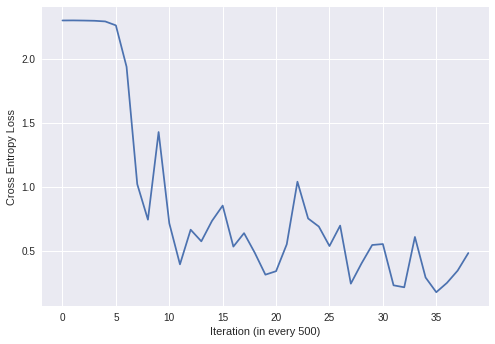

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (Iteration_loss)
plt.plot(Iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

# modified hyper perameter

In [ ]:
batch_size = 256;
num_iters = 30000;
input_dim = 28*28; #num_features = 784
output_dim = 10;
learning_rate = 0.01;
num_nodes_in_hidden_layers = 200;
num_hidden_layers = 3;
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device);

cuda:0


In [ ]:
num_epochs = num_iters / (len(train_dataset_zipped) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset_zipped, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset_zipped, 
                                          batch_size=batch_size, 
                                          shuffle=False) 
print(len(train_loader));
print(len(test_loader));

219
55


In [ ]:
import torch.nn as nn
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        
        self.relu_1 = nn.ReLU()
 
        
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_2 = nn.ReLU()
 
        
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_3 = nn.ReLU()
 
         
 
        
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
 
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [ ]:

 
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_nodes_in_hidden_layers)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
Iteration_loss1 =[]
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
 
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
 
        # Forward pass to get output/logits
        outputs = model(images.float()) 
 
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
 
        # Getting gradients w.r.t. parameters
        loss.backward()
 
        # Updating parameters
        optimizer.step()
 
        iter += 1
 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)
 
                # Forward pass only to get logits/output
                outputs = model(images.float())
 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
 
                # Total number of labels
                total += labels.size(0)
 
 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()
 
            accuracy = 100 * correct.item() / total
 
            # Print Loss
            Iteration_loss1.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.6522284746170044. Accuracy: 41.5
Iteration: 1000. Loss: 1.0177981853485107. Accuracy: 61.892857142857146
Iteration: 1500. Loss: 0.8063068985939026. Accuracy: 67.42857142857143
Iteration: 2000. Loss: 0.6464027166366577. Accuracy: 73.08571428571429
Iteration: 2500. Loss: 0.6706095337867737. Accuracy: 76.44285714285714
Iteration: 3000. Loss: 0.6328266859054565. Accuracy: 77.98571428571428
Iteration: 3500. Loss: 0.5612757205963135. Accuracy: 79.43571428571428
Iteration: 4000. Loss: 0.5496611595153809. Accuracy: 80.35714285714286
Iteration: 4500. Loss: 0.41332730650901794. Accuracy: 80.47142857142858
Iteration: 5000. Loss: 0.4312349557876587. Accuracy: 81.94285714285714
Iteration: 5500. Loss: 0.4130924344062805. Accuracy: 82.3
Iteration: 6000. Loss: 0.4558914005756378. Accuracy: 82.75714285714285
Iteration: 6500. Loss: 0.44191840291023254. Accuracy: 82.05714285714286
Iteration: 7000. Loss: 0.4014368951320648. Accuracy: 83.05714285714286
Iteration: 7500. Loss: 0.51219

# loss vs iteration 


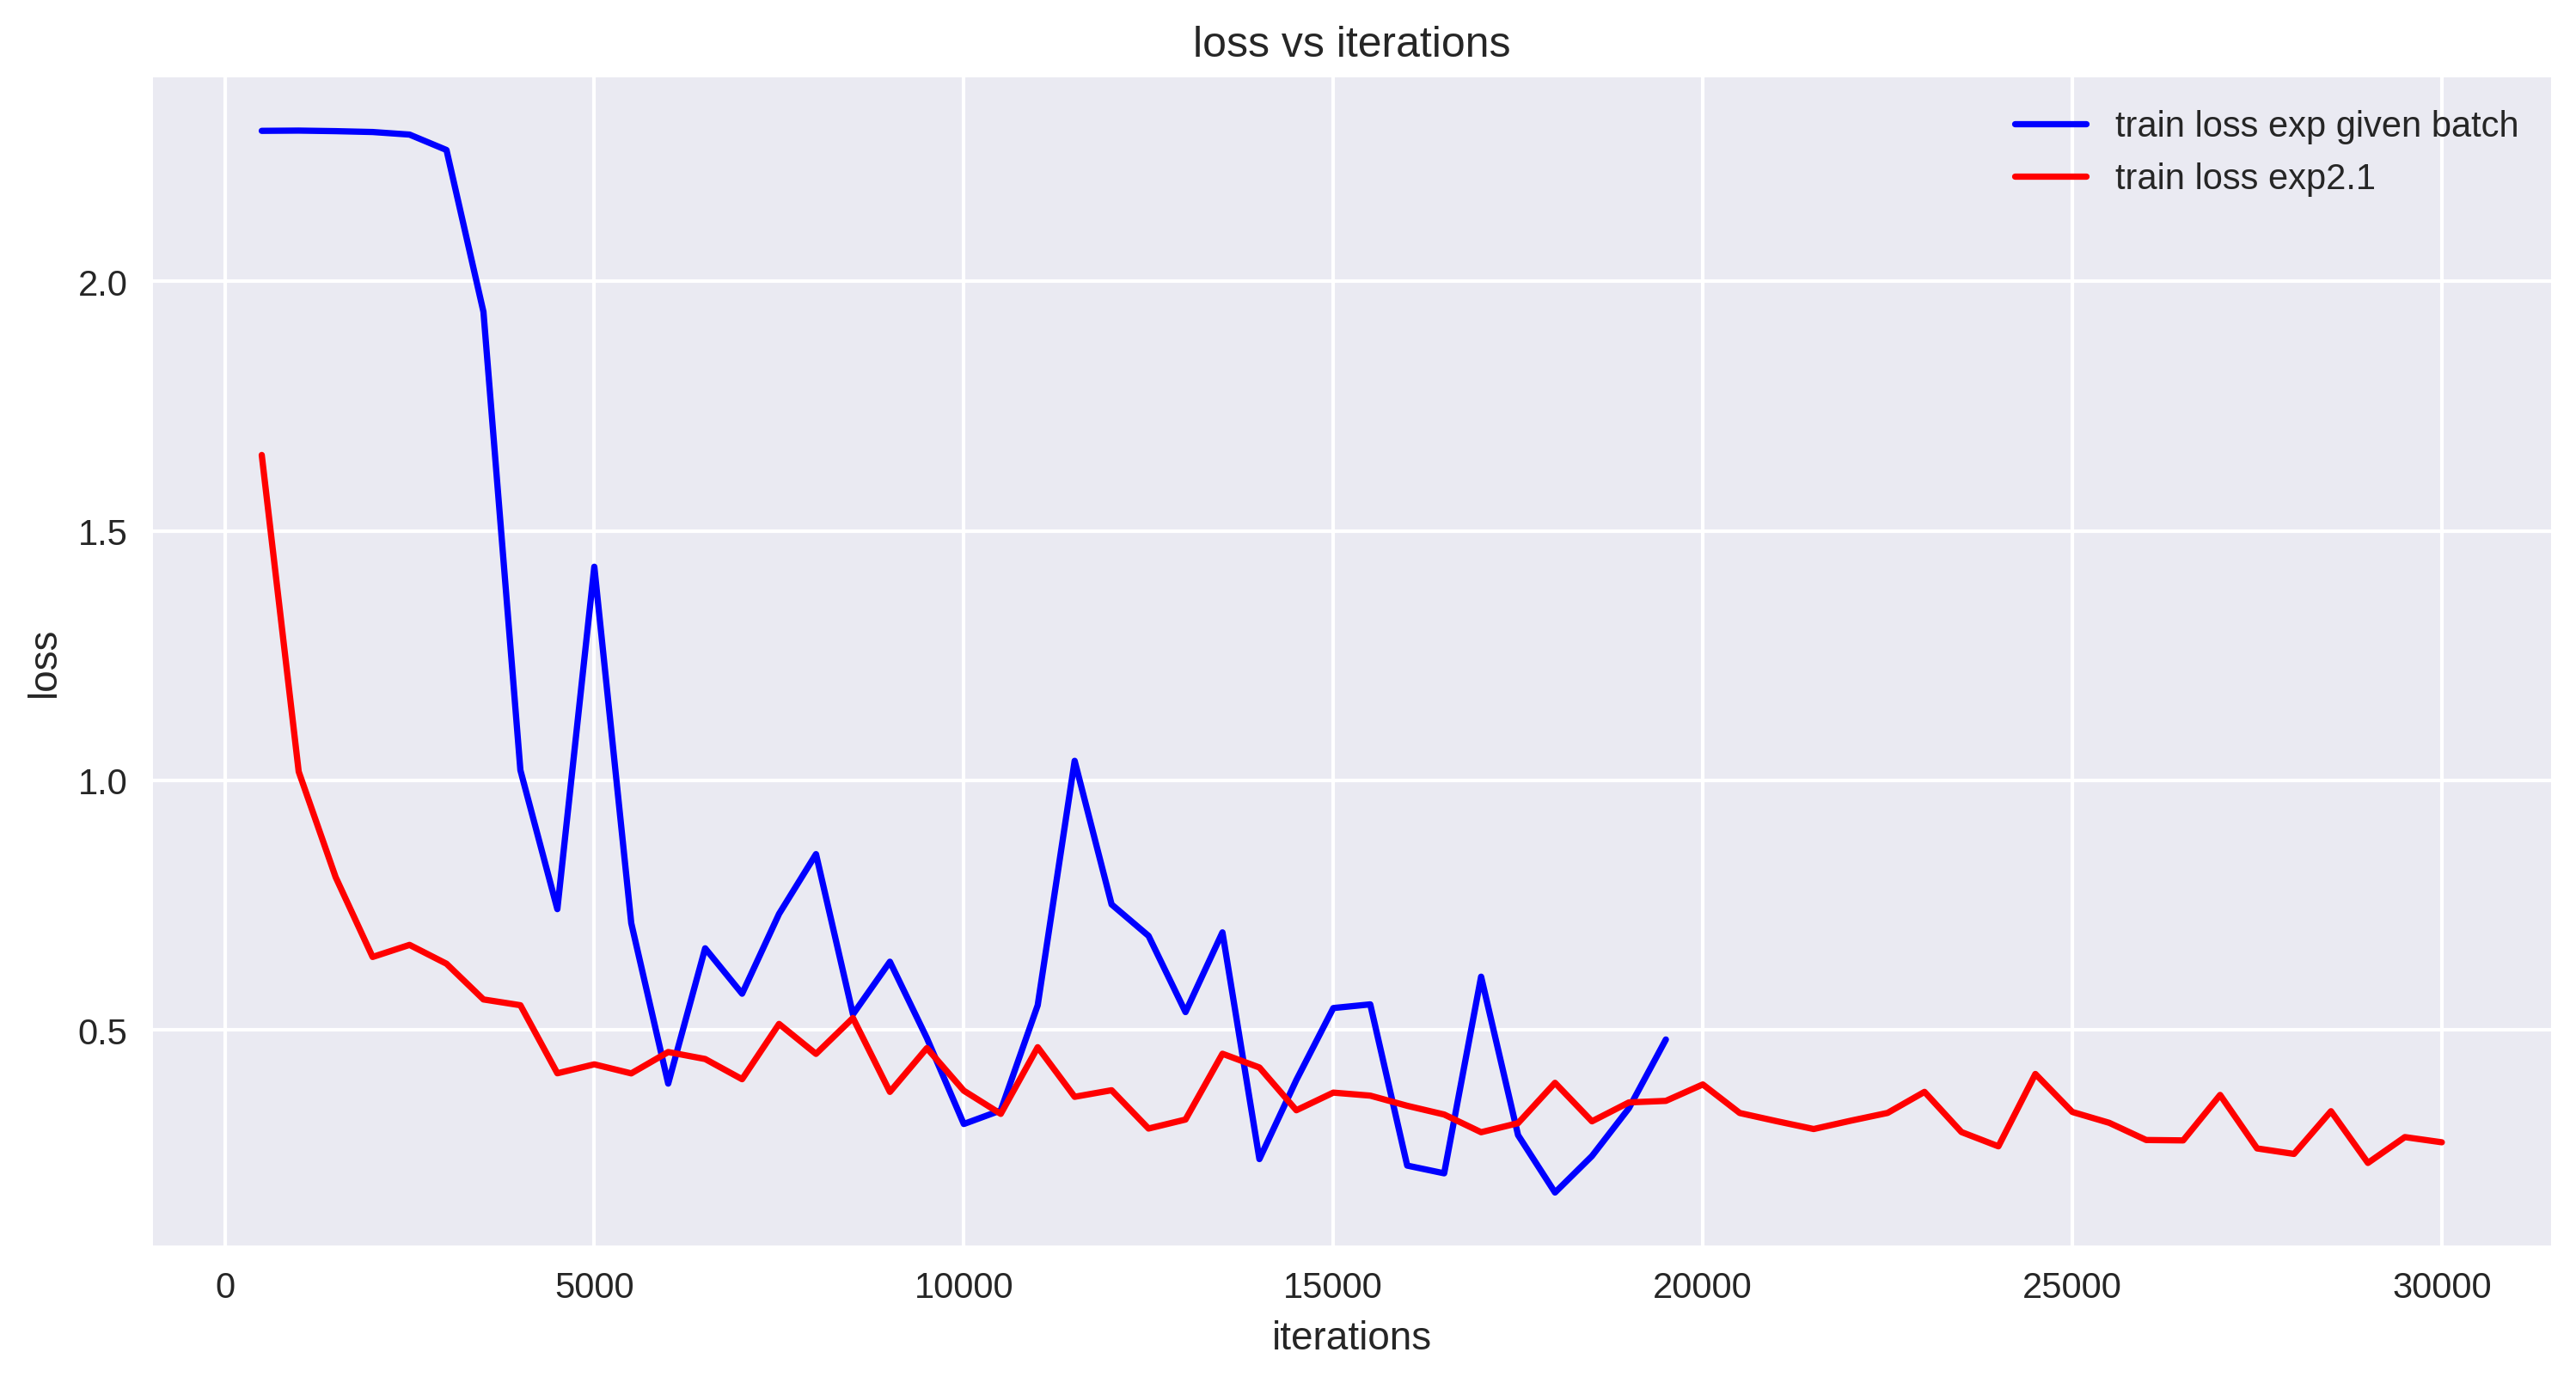

In [ ]:
plt.figure(figsize=(12,6),dpi=300);
plt.style.use('seaborn');
plt.plot(iterations[0:39] , Iteration_loss, color='blue',label='train loss exp given batch');
plt.plot(iterations , Iteration_loss1, color='red',label='train loss exp2.1');
plt.title('loss vs iterations');
plt.xlabel('iterations');
plt.ylabel('loss');
plt.grid(True); #create a grid layout
plt.legend();
plt.show()